# DQN vs DDPG: A Comparative Study on Pendulum-v0
## DELE PART C
## Name: Rajarethinam Abarna
## Class: DAAA/FT/2B/22
## Admin No: p2415857

In [1]:
# ===== IMPORTS =====
import gym
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import random
from collections import deque

### Deep Q-Network (DQN) Training

This section implements the Deep Q-Network (DQN) algorithm on the Pendulum-v0 environment. Since DQN is inherently designed for discrete action spaces, we discretize the continuous action range of the pendulum into 5 bins. The agent selects actions using an ε-greedy policy and updates its Q-network using experience replay.

As training progresses, the agent learns to apply appropriate torque to swing and balance the pendulum, though discretization introduces limitations in achieving smooth control. The printed reward per episode and epsilon value illustrate the agent’s learning trajectory and exploration decay. Over time, the DQN agent becomes less exploratory and improves its control policy within the discretized action space.

In [2]:
np.random.seed(0)
tf.random.set_seed(0)
random.seed(0)

env = gym.make("Pendulum-v0")
state_dim = env.observation_space.shape[0]
action_low = env.action_space.low[0]
action_high = env.action_space.high[0]

# ===== DQN AGENT =====
class DQNAgent:
    def __init__(self, state_dim, action_bins):
        self.state_dim = state_dim
        self.action_bins = action_bins
        self.action_size = len(action_bins)
        self.memory = deque(maxlen=2000)
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.995
        self.model = self._build_model()

    def _build_model(self):
        model = tf.keras.Sequential([
            tf.keras.Input(shape=(self.state_dim,)),
            layers.Dense(64, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(self.action_size, activation='linear')
        ])
        model.compile(optimizer='adam', loss='mse')
        return model

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.choice(range(self.action_size))
        q_values = self.model.predict(np.array([state]), verbose=0)
        return np.argmax(q_values[0])

    def remember(self, s, a, r, s2, done):
        self.memory.append((s, a, r, s2, done))

    def train(self, batch_size=32):
        minibatch = random.sample(self.memory, min(len(self.memory), batch_size))
        for s, a, r, s2, done in minibatch:
            target = self.model.predict(np.array([s]), verbose=0)[0]
            target[a] = r if done else r + self.gamma * np.amax(self.model.predict(np.array([s2]), verbose=0)[0])
            self.model.fit(np.array([s]), np.array([target]), epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# ===== TRAIN DQN =====
action_bins = np.linspace(action_low, action_high, 5)
dqn_agent = DQNAgent(state_dim, action_bins)

dqn_rewards = []
print("\n Training DQN...")
for ep in range(100):
    state = env.reset()
    total_reward = 0
    for _ in range(200):
        idx = dqn_agent.act(state)
        action = [action_bins[idx]]
        next_state, reward, done, _ = env.step(action)
        dqn_agent.remember(state, idx, reward, next_state, done)
        state = next_state
        total_reward += reward
        if done:
            break
    dqn_agent.train()
    dqn_rewards.append(total_reward)
    print(f"DQN Episode {ep+1:3d} | Reward: {total_reward:7.2f} | Epsilon: {dqn_agent.epsilon:.2f}")


 Training DQN...
DQN Episode   1 | Reward: -1235.55 | Epsilon: 0.99
DQN Episode   2 | Reward: -966.07 | Epsilon: 0.99
DQN Episode   3 | Reward: -1743.21 | Epsilon: 0.99
DQN Episode   4 | Reward: -953.04 | Epsilon: 0.98
DQN Episode   5 | Reward: -1054.70 | Epsilon: 0.98
DQN Episode   6 | Reward: -1500.28 | Epsilon: 0.97
DQN Episode   7 | Reward: -980.00 | Epsilon: 0.97
DQN Episode   8 | Reward: -1348.69 | Epsilon: 0.96
DQN Episode   9 | Reward: -859.27 | Epsilon: 0.96
DQN Episode  10 | Reward: -1227.20 | Epsilon: 0.95
DQN Episode  11 | Reward: -1074.62 | Epsilon: 0.95
DQN Episode  12 | Reward: -1409.69 | Epsilon: 0.94
DQN Episode  13 | Reward: -976.94 | Epsilon: 0.94
DQN Episode  14 | Reward: -1095.84 | Epsilon: 0.93
DQN Episode  15 | Reward: -1342.03 | Epsilon: 0.93
DQN Episode  16 | Reward: -975.54 | Epsilon: 0.92
DQN Episode  17 | Reward: -1272.38 | Epsilon: 0.92
DQN Episode  18 | Reward: -1080.02 | Epsilon: 0.91
DQN Episode  19 | Reward: -894.59 | Epsilon: 0.91
DQN Episode  20 | Re

### Deep Deterministic Policy Gradient (DDPG) Training

This section implements the DDPG algorithm, a deep reinforcement learning method designed specifically for continuous action spaces like those in the Pendulum-v0 environment. Unlike DQN, which selects from a discrete set of actions, DDPG uses an *actor-critic* architecture. The **actor network** maps observed states directly to continuous actions, while the **critic network** estimates the Q-value of state-action pairs.

To encourage exploration in continuous space, DDPG adds **Ornstein-Uhlenbeck noise** to the actor’s actions, generating smooth, temporally correlated perturbations that are better suited to physical control problems. The algorithm also uses **experience replay** and **soft target network updates** to stabilize learning.

During training, the agent stores transitions in a replay buffer and periodically samples mini-batches to update both the actor and critic networks. This setup enables the agent to learn precise torque values to swing and balance the pendulum upright over time. The reward per episode printed below tracks the agent’s progress as it learns increasingly effective continuous control policies.

In [3]:
# ===== DDPG AGENT =====
class OUActionNoise:
    def __init__(self, mean, std_dev):
        self.theta = 0.15
        self.mean = mean
        self.std_dev = std_dev
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mean - self.x_prev) + self.std_dev * np.random.normal(size=self.mean.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = np.zeros_like(self.mean)

class ReplayBuffer:
    def __init__(self, maxlen=100000, batch_size=64):
        self.buffer = deque(maxlen=maxlen)
        self.batch_size = batch_size

    def add(self, s, a, r, s2):
        self.buffer.append((np.array(s, dtype=np.float32), float(a), float(r), np.array(s2, dtype=np.float32)))

    def sample(self):
        minibatch = random.sample(self.buffer, min(len(self.buffer), self.batch_size))
        s, a, r, s2 = zip(*minibatch)
        s = np.stack(s)
        a = np.array(a).reshape(-1, 1)
        r = np.array(r).reshape(-1, 1)
        s2 = np.stack(s2)
        return s, a, r, s2

class DDPGAgent:
    def __init__(self):
        self.gamma = 0.99
        self.tau = 0.005
        self.buffer = ReplayBuffer()
        self.actor = self.build_actor()
        self.critic = self.build_critic()
        self.target_actor = self.build_actor()
        self.target_critic = self.build_critic()
        self.target_actor.set_weights(self.actor.get_weights())
        self.target_critic.set_weights(self.critic.get_weights())
        self.actor_opt = tf.keras.optimizers.Adam(1e-3)
        self.critic_opt = tf.keras.optimizers.Adam(2e-3)
        self.noise = OUActionNoise(mean=np.zeros(1), std_dev=0.2 * np.ones(1))

    def build_actor(self):
        model = tf.keras.Sequential([
            tf.keras.Input(shape=(state_dim,)),
            layers.Dense(64, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(1, activation='tanh')
        ])
        return model

    def build_critic(self):
        s = tf.keras.Input(shape=(state_dim,))
        a = tf.keras.Input(shape=(1,))
        x = layers.Concatenate()([s, a])
        x = layers.Dense(64, activation='relu')(x)
        x = layers.Dense(64, activation='relu')(x)
        out = layers.Dense(1)(x)
        return tf.keras.Model([s, a], out)

    def act(self, state):
        a = self.actor(np.array([state])).numpy()[0]
        return np.clip(a + self.noise(), action_low, action_high).item()

    def update(self):
        if len(self.buffer.buffer) < self.buffer.batch_size:
            return
        s, a, r, s2 = self.buffer.sample()

        # Update critic
        with tf.GradientTape() as tape:
            target_actions = self.target_actor(s2)
            y = r + self.gamma * self.target_critic([s2, target_actions])
            critic_loss = tf.reduce_mean(tf.square(y - self.critic([s, a])))
        grads = tape.gradient(critic_loss, self.critic.trainable_variables)
        self.critic_opt.apply_gradients(zip(grads, self.critic.trainable_variables))

        # Update actor
        with tf.GradientTape() as tape:
            actor_loss = -tf.reduce_mean(self.critic([s, self.actor(s)]))
        grads = tape.gradient(actor_loss, self.actor.trainable_variables)
        self.actor_opt.apply_gradients(zip(grads, self.actor.trainable_variables))

        # Soft update
        for t, m in zip(self.target_actor.variables, self.actor.variables):
            t.assign(self.tau * m + (1 - self.tau) * t)
        for t, m in zip(self.target_critic.variables, self.critic.variables):
            t.assign(self.tau * m + (1 - self.tau) * t)

# ===== TRAIN DDPG =====
ddpg_agent = DDPGAgent()
ddpg_rewards = []
print("\n Training DDPG...")
for ep in range(100):
    state = env.reset()
    total_reward = 0
    for _ in range(200):
        action = ddpg_agent.act(state)
        next_state, reward, done, _ = env.step([action])
        ddpg_agent.buffer.add(state, action, reward, next_state)
        ddpg_agent.update()
        state = next_state
        total_reward += reward
        if done:
            break
    ddpg_rewards.append(total_reward)
    print(f"DDPG Episode {ep+1:3d} | Reward: {total_reward:7.2f}")


 Training DDPG...
DDPG Episode   1 | Reward: -1143.09
DDPG Episode   2 | Reward: -1267.83
DDPG Episode   3 | Reward: -1212.02
DDPG Episode   4 | Reward: -1726.61
DDPG Episode   5 | Reward: -1238.16
DDPG Episode   6 | Reward: -1567.74
DDPG Episode   7 | Reward: -1263.55
DDPG Episode   8 | Reward: -1325.10
DDPG Episode   9 | Reward: -1221.92
DDPG Episode  10 | Reward: -1147.31
DDPG Episode  11 | Reward: -1005.92
DDPG Episode  12 | Reward: -944.78
DDPG Episode  13 | Reward: -844.81
DDPG Episode  14 | Reward: -760.75
DDPG Episode  15 | Reward: -878.15
DDPG Episode  16 | Reward: -252.96
DDPG Episode  17 | Reward: -366.77
DDPG Episode  18 | Reward: -496.96
DDPG Episode  19 | Reward: -248.04
DDPG Episode  20 | Reward: -459.75
DDPG Episode  21 | Reward: -251.49
DDPG Episode  22 | Reward: -503.44
DDPG Episode  23 | Reward: -364.52
DDPG Episode  24 | Reward: -373.24
DDPG Episode  25 | Reward: -254.69
DDPG Episode  26 | Reward: -127.21
DDPG Episode  27 | Reward: -121.85
DDPG Episode  28 | Reward

###  Reward Curves: Comparing DQN and DDPG Performance

The graph below shows the total reward per episode for both DQN and DDPG agents across 100 episodes in the Pendulum-v0 environment. These curves help visualize how well each algorithm is learning to control the pendulum over time.

- **DQN (Discrete)**: The DQN curve typically fluctuates and improves slowly due to the limitations of action discretization. Since the pendulum environment requires fine-grained torque control, the coarse bins of DQN hinder smooth learning. The curve may plateau early, showing signs of suboptimal performance.

- **DDPG (Continuous)**: In contrast, DDPG demonstrates a smoother and often more stable learning trajectory. Since it directly outputs continuous actions via its actor network, it can learn nuanced torque applications better suited to the task. The reward curve may start low but tends to improve consistently as the actor and critic networks co-adapt.

Overall, the reward curves highlight that DDPG is more effective in continuous control scenarios like Pendulum-v0, supporting the architectural advantages of actor-critic methods in such environments.

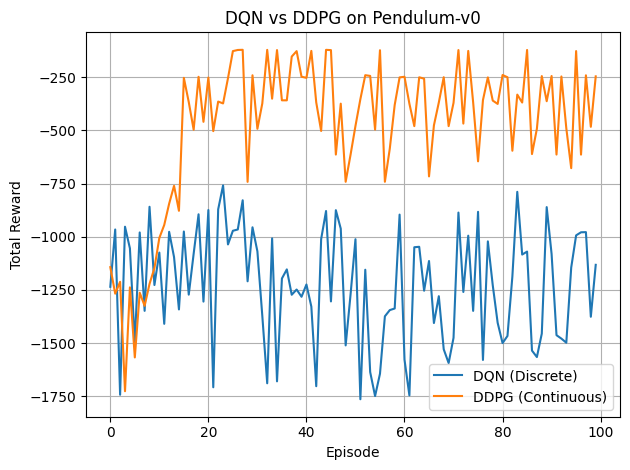

In [4]:
# ===== PLOT COMPARISON =====
plt.plot(dqn_rewards, label="DQN (Discrete)")
plt.plot(ddpg_rewards, label="DDPG (Continuous)")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQN vs DDPG on Pendulum-v0")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()